# COMP 551 Assignment 2

## Task 1: Acquire the data

In [3]:
%pip install matplotlib
import torch as t
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision as tv
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math

device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(t.cuda.is_available())
# Suppress warnings
warnings.filterwarnings("ignore")

# Directory to store datasets
dir = "./data"


     ---------------------------------------- 7.6/7.6 MB 23.3 MB/s eta 0:00:00
     ---------------------------------------- 56.1/56.1 kB ? eta 0:00:00
     ---------------------------------------- 186.7/186.7 kB ? eta 0:00:00
     ---------------------------------------- 103.1/103.1 kB ? eta 0:00:00
     ---------------------------------------- 2.1/2.1 MB 22.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


True


### Dataset 1: Fashion MNIST

100%|██████████| 26421880/26421880 [00:04<00:00, 6022926.89it/s] 


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 316079.03it/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3809413.12it/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw

Training set size: 60000
Test set size: 10000


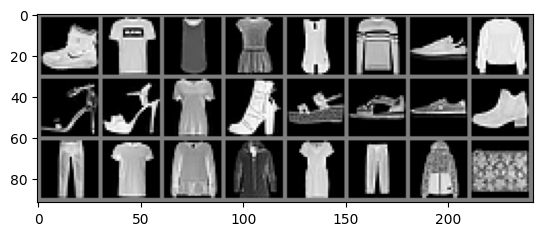

Ankle boot T-shirt/top T-shirt/top Dress T-shirt/top Pullover Sneaker Pullover Sandal Sandal T-shirt/top Ankle boot Sandal Sandal Sneaker Ankle boot Trouser T-shirt/top Shirt Coat Dress Trouser Coat Bag


In [4]:
def load_fashionMNIST(root_dir, train=True, download=True):
    transform = tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Normalize((0.5), (0.5))
    ])
    
    return tv.datasets.FashionMNIST(root=root_dir, train=train, transform=transform, download=download)

def visualize_samples(dataset, num_samples, class_names):
    data_loader = t.utils.data.DataLoader(dataset, batch_size=num_samples, shuffle=False)
    images, labels = next(iter(data_loader))
    
    grid = tv.utils.make_grid(images)
    grid = (grid+1)/2
    plt.imshow(grid.numpy().transpose((1, 2, 0)), cmap='gray')
    plt.show()
    
    print(' '.join(f'{class_names[label]}' for label in labels))

def data_reshape(dataset, batch_size):
    data_loader = t.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=(batch_size != len(dataset)))
    X_tensor, y_tensor = next(iter(data_loader))
    
    X = X_tensor.numpy().reshape((batch_size, -1))
    y = y_tensor.numpy()
    
    return X, y, X_tensor, y_tensor


train_datasetF = load_fashionMNIST(dir, train=True)
test_datasetF = load_fashionMNIST(dir, train=False)
    
print(f"Training set size: {len(train_datasetF)}")
print(f"Test set size: {len(test_datasetF)}")
    
class_namesF = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
    
# Visualize 24 samples
visualize_samples(train_datasetF, 24, class_namesF)
    
# Load training and test data
X_trainF, y_trainF, _, _ = data_reshape(train_datasetF, 1024)
X_testF, y_testF, test_dataF_X_tensor, test_dataF_y_tensor = data_reshape(test_datasetF, 10000)
    
datasetF = {
        'X_train': X_trainF,
        'y_train': y_trainF,
        'X_test': X_testF,
        'y_test': y_testF
    }

test_dataF = {'X': test_dataF_X_tensor, 'y': test_dataF_y_tensor}

### Dataset 2: CIFAR 10

100%|██████████| 170498071/170498071 [00:05<00:00, 30112491.01it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training set size: 50000
Test set size: 10000


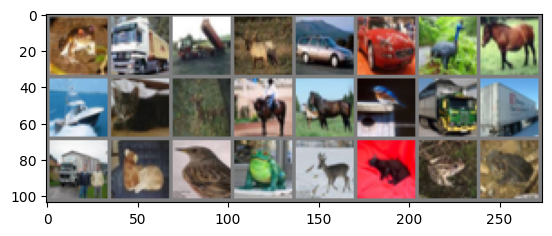

frog truck truck deer car car bird horse ship cat deer horse horse bird truck truck truck cat bird frog deer cat frog frog


In [5]:
# Classes
class_nameC = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
train_sizeC = 1024
test_sizeC = 10000

# Setup transformations for CIFAR10 that perform normalization and transfer to tensor
transformC = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR10 dataset
train_datasetC = tv.datasets.CIFAR10(root=dir, train=True, transform=transformC, download=True)
test_datasetC = tv.datasets.CIFAR10(root=dir, train=False, transform=transformC, download=True)

# Get dataset sizes
print(f"Training set size: {len(train_datasetC)}")
print(f"Test set size: {len(test_datasetC)}")

def show_img(img, colored=False):
    img = (img+1)/2
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg, cmap=None if colored else 'gray')
    plt.show()

# Visualize 24 images
sample_loaderC = t.utils.data.DataLoader(train_datasetC, batch_size=24, shuffle=False)
imgiterC = iter(sample_loaderC)
imageC, labelC = next(imgiterC)
show_img(tv.utils.make_grid(imageC), colored=True)
print(' '.join(f'{class_nameC[labelC[i]]}' for i in range(24)))

train_loaderC = t.utils.data.DataLoader(train_datasetC, batch_size=train_sizeC, shuffle=True)
X_tensorC, y_tensorC = next(iter(train_loaderC))
XC = X_tensorC.numpy().reshape((train_sizeC, -1))
yC = y_tensorC.numpy()

subset__train_dataC = t.utils.data.Subset(train_datasetC, range(train_sizeC))
subset_train_iterC = t.utils.data.DataLoader(subset__train_dataC, batch_size=128, shuffle=True)

test_loaderC = t.utils.data.DataLoader(test_datasetC, batch_size=test_sizeC, shuffle=True)
X_test_tensorC, y_test_tensorC = next(iter(test_loaderC))
X_testC = X_test_tensorC.numpy().reshape((test_sizeC, -1))
y_testC = y_test_tensorC.numpy()


## Task 2: Implement a Multilayer Perceptron (MLP)

In [6]:
class MLP:
    def __init__(self, ac, ac_derivative, Class=10, hidden=2, units=[128, 128], 
                 initializer="Xavier", regularization=0, regularization_coeff=0.001):
        assert len(units) == hidden
        self.ac = ac 
        self.ac_derivative = ac_derivative
        self.Class = Class
        self.hidden = hidden
        self.units = units
        self.initializer = initializer
        self.regularization = regularization
        self.regularization_coeff = regularization_coeff
        np.random.seed(33)
        
        # Mapping for initialization methods
        self.init_methods = {
            "Zero": self.zero_init,
            "Uniform": self.uniform_init,
            "Gaussian": self.gaussian_init,
            "Xavier": self.xavier_init,
            "Kaiming": self.kaiming_init
        }

    def zero_init(self, row, column):
        return np.zeros((row, column)), np.zeros(column)

    def uniform_init(self, row, column):
        return np.random.uniform(-1, 1, (row, column)), np.random.uniform(-1, 1, column)

    def gaussian_init(self, row, column):
        return np.random.randn(row, column), np.random.randn(column)

    def xavier_init(self, row, column):
        hi = 1 / np.sqrt(row)
        return np.random.uniform(-hi, hi, (row, column)), np.random.uniform(-hi, hi, column)

    def kaiming_init(self, row, column):
        variance = 2 / row
        return np.random.randn(row, column) * np.sqrt(variance), np.zeros(column)

    def param_init(self, X):
        N, D = X.shape
        self.weights = []
        self.biases = []
        for i in range(self.hidden + 1):
            row = D if i == 0 else self.units[i-1]
            column = self.Class if i == self.hidden else self.units[i]
            weight, bias = self.init_methods[self.initializer](row, column)
            self.weights.append(weight)
            self.biases.append(bias)

    def softmax(self, a):
        e = np.exp(a - np.max(a))
        return e / np.sum(e, axis=1, keepdims=True)

    def calculate_loss(self, predictions, y):
        assert len(y) == len(predictions)
        if y.ndim == 1:
            y = np.eye(self.Class)[y]
        N, C = y.shape
        return -1 * np.sum(y * np.log(predictions)) / N

    def calculate_accuracy(self, predictions, y):
        assert len(y) == len(predictions)
        return np.mean(y == predictions)

    def calculate_metric_given_X(self, X, y):
        raw = self.predict(X, raw=True)
        predictions = np.argmax(raw, axis=1)
        return self.calculate_loss(raw, y), self.calculate_accuracy(predictions, y)

    def fit(self, X, y, lr=0.01, batchsize=256, epochs=1000):
        self.param_init(X)

        y_one_hot = np.eye(self.Class)[y]
        N, D = X.shape
        loss_per_step = []
        regularization_loss_per_step = []
        accuracy_per_step = []

        for epoch in range(epochs):
            indices = np.random.permutation(N)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            y_one_hot_shuffled = y_one_hot[indices]

            for i in range(0, N, batchsize):
                X_batch = X_shuffled[i:i+batchsize]
                y_one_hot_batch = y_one_hot_shuffled[i:i+batchsize]

                # Forward
                activations = [X_batch]
                z_values = []
                for j in range(len(self.weights)):
                    z = activations[-1] @ self.weights[j] + self.biases[j]
                    activations.append(self.ac(z))
                    z_values.append(z)
                
                probabilities = self.softmax(activations[-1])
                predictions = np.argmax(probabilities, axis=1)
                
                # Compute regularization loss
                regularization_loss = 0
                if self.regularization == 1:
                    for matrix in self.weights:
                        regularization_loss += np.sum(np.absolute(matrix))
                    for vector in self.biases:
                        regularization_loss += np.sum(np.absolute(vector))
                elif self.regularization == 2:
                    for matrix in self.weights:
                        regularization_loss += np.linalg.norm(matrix, ord='fro') ** 2
                    for vector in self.biases:
                        regularization_loss += np.linalg.norm(vector) ** 2
                regularization_loss *= self.regularization_coeff

                regularization_loss_per_step.append(regularization_loss / N)
                loss_per_step.append(self.calculate_loss(probabilities, y_one_hot_batch))
                accuracy_per_step.append(self.calculate_accuracy(predictions, y_shuffled[i:i+batchsize]))
                
                # Backward
                y_hat = probabilities
                dL_da = y_hat - y_one_hot_batch
                dL_dz = dL_da * self.ac_derivative(z_values[-1])

                deltas = [dL_dz]
                for j in range(self.hidden - 1, -1, -1):
                    delta = (deltas[-1] @ self.weights[j+1].T) * self.ac_derivative(z_values[j])
                    deltas.append(delta)

                deltas = deltas[::-1]
                for j in range(self.hidden + 1):
                    self.weights[j] -= lr * (activations[j].T @ deltas[j]) / N
                    self.biases[j] -= lr * np.sum(deltas[j], axis=0) / N
                    if self.regularization == 1:
                        self.weights[j] -= lr * self.regularization_coeff * np.sign(self.weights[j])
                        self.biases[j] -= lr * self.regularization_coeff * np.sign(self.biases[j])
                    elif self.regularization == 2:
                        self.weights[j] -= lr * 2 * self.regularization_coeff * self.weights[j]
                        self.biases[j] -= lr * 2 * self.regularization_coeff * self.biases[j]

        return loss_per_step, regularization_loss_per_step, accuracy_per_step

    def predict(self, X, raw=False):
        activations = [X]
        for i in range(len(self.weights)):
            z = activations[-1] @ self.weights[i] + self.biases[i]
            activations.append(self.ac(z))
        predictions = self.softmax(activations[-1])
        if raw:
            return predictions
        return np.argmax(predictions, axis=1)


## Task 3: Run the experiments and report

### 3.1 Adding different initialization

Training model with Zero initialization...
Training model with Uniform initialization...
Training model with Gaussian initialization...
Training model with Xavier initialization...
Training model with Kaiming initialization...


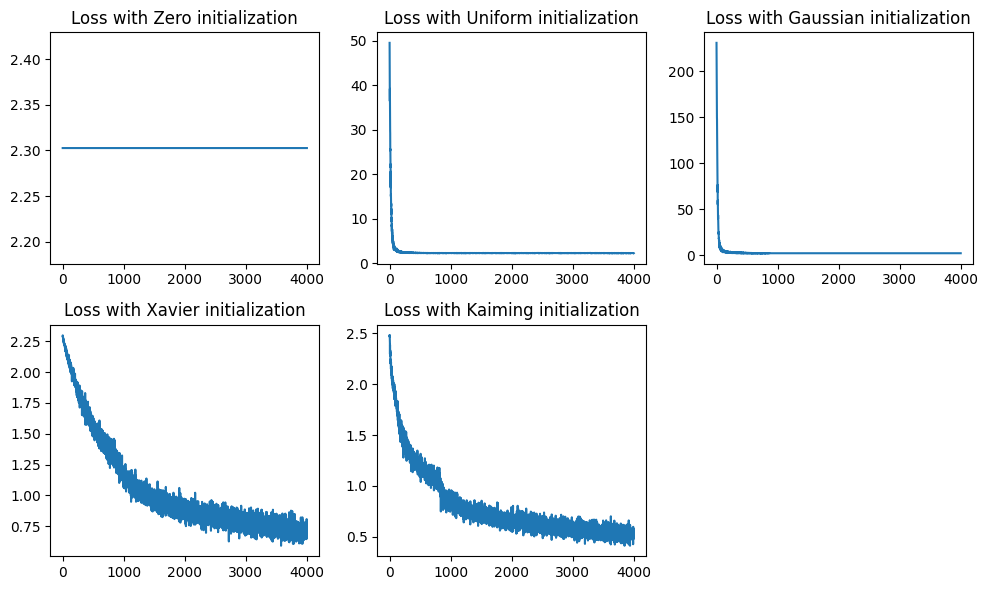

Accuracy with Zero initialization: 0.1
Accuracy with Uniform initialization: 0.1085
Accuracy with Gaussian initialization: 0.1026
Accuracy with Xavier initialization: 0.6958
Accuracy with Kaiming initialization: 0.7197


In [7]:
def ReLU(i):
    return i * (i > 0)

def ReLU_derivative(i):
    return 1.0 * (i > 0)
class Experiment31:

    def __init__(self, dataset):
        self.dataset = dataset
        self.initializers = ["Zero", "Uniform", "Gaussian", "Xavier", "Kaiming"]
        self.losses = []
        self.accuracies = []

    def run_experiments(self):
        for init in self.initializers:
            print(f"Training model with {init} initialization...")
            model = MLP(ReLU, ReLU_derivative, hidden=1, units=[128], initializer=init)
            loss, _, _ = model.fit(self.dataset['X_train'], self.dataset['y_train'], epochs=1000)
            self.losses.append(loss)
            _, accuracy = model.calculate_metric_given_X(self.dataset['X_test'], self.dataset['y_test'])
            self.accuracies.append(accuracy)

    def plot_results(self):
        plt.figure(figsize=(10, 6))
        for i, loss in enumerate(self.losses):
            plt.subplot(2, 3, i+1)
            plt.plot(loss)
            plt.title(f"Loss with {self.initializers[i]} initialization")
        plt.tight_layout()
        plt.show()

    def print_accuracies(self):
        for init, accuracy in zip(self.initializers, self.accuracies):
            print(f"Accuracy with {init} initialization: {accuracy}")

experiment_runner = Experiment31(datasetF)
experiment_runner.run_experiments()
experiment_runner.plot_results()
experiment_runner.print_accuracies()


### 3.2: Adding different number of layers

Training model with 0 hidden layers...
Training model with 1 hidden layers...
Training model with 2 hidden layers...


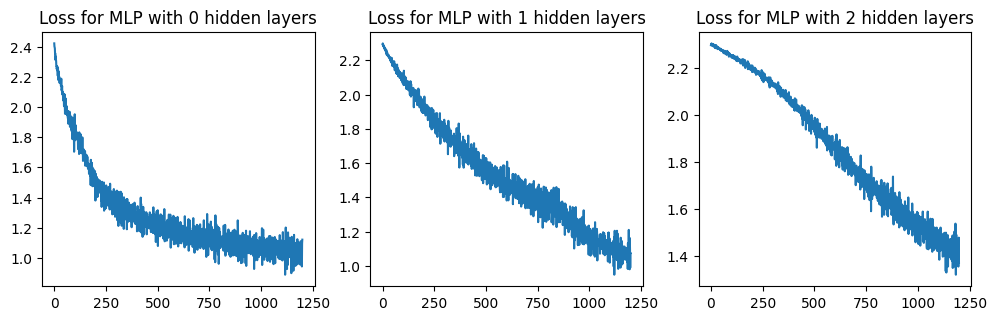

Accuracy for MLP with 0 hidden layers: 0.62
Accuracy for MLP with 1 hidden layers: 0.65
Accuracy for MLP with 2 hidden layers: 0.52


In [8]:

class Experiment32:
    def __init__(self, dataset):
        self.dataset = dataset
        self.losses = []
        self.accuracies = []

    def train_and_evaluate(self):
        for i in range(3):
            print(f"Training model with {i} hidden layers...")
            model = MLP(ReLU, ReLU_derivative, hidden=i, units=[128] * i, initializer="Xavier")
            
            # Train the model
            loss, _, _ = model.fit(self.dataset['X_train'], self.dataset['y_train'], epochs=300)
            self.losses.append(loss)

            # Evaluate the model
            _, accuracy = model.calculate_metric_given_X(self.dataset['X_test'], self.dataset['y_test'])
            self.accuracies.append(accuracy)

    def plot_results(self):
        plt.figure(figsize=(10, 6))
        for i, loss in enumerate(self.losses):
            plt.subplot(2, 3, i+1)
            plt.plot(loss)
            plt.title(f"Loss for MLP with {i} hidden layers")
        plt.tight_layout()
        plt.show()

    def print_accuracies(self):
        for i, accuracy in enumerate(self.accuracies):
            print(f"Accuracy for MLP with {i} hidden layers: {accuracy:.2f}")


model_runner = Experiment32(datasetF)
model_runner.train_and_evaluate()
model_runner.plot_results()
model_runner.print_accuracies()


### 3.3: Adding different activations

Training model with ReLU activation...
Training model with logistic activation...
Training model with softplus activation...


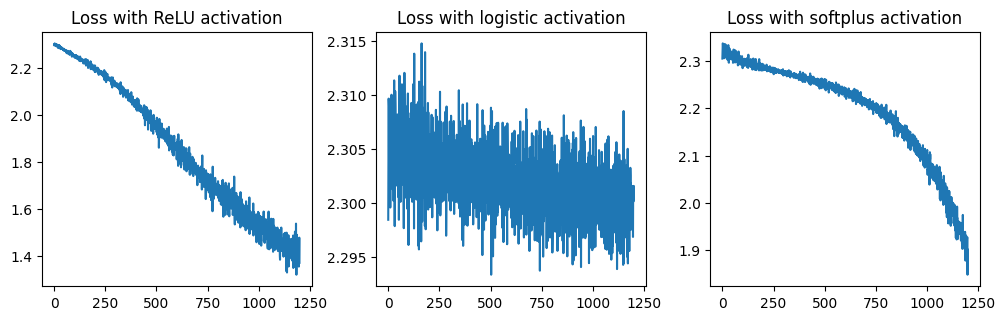

Accuracy with ReLU activation: 0.52
Accuracy with logistic activation: 0.10
Accuracy with softplus activation: 0.37


In [9]:

def logistic(x):
    return 1 / (np.exp(-x) + 1)

def logistic_derivative(x):
    tmp = np.exp(-x)
    return tmp / (1 + tmp) ** 2

def softplus(x):
    return np.log1p(np.exp(x))

def softplus_derivative(x):
    tmp = np.exp(x)
    return tmp / (1 + tmp)

class Experiment33:

    def __init__(self, dataset):
        self.dataset = dataset
        self.activations = [ReLU, logistic, softplus]
        self.activation_derivatives = [ReLU_derivative, logistic_derivative, softplus_derivative]
        self.names = ["ReLU", "logistic", "softplus"]
        self.losses = []
        self.accuracies = []

    def run_experiments(self):

        for i in range(3):
            print(f"Training model with {self.names[i]} activation...")
            model = MLP(self.activations[i], self.activation_derivatives[i], hidden=2, units=[128, 128], initializer="Xavier")
            
            # Train the model
            loss, _, _ = model.fit(self.dataset['X_train'], self.dataset['y_train'], epochs=300)
            self.losses.append(loss)

            # Evaluate the model
            _, accuracy = model.calculate_metric_given_X(self.dataset['X_test'], self.dataset['y_test'])
            self.accuracies.append(accuracy)

    def plot_results(self):
        plt.figure(figsize=(10, 6))
        for i, loss in enumerate(self.losses):
            plt.subplot(2, 3, i+1)
            plt.plot(loss)
            plt.title(f"Loss with {self.names[i]} activation")
        plt.tight_layout()
        plt.show()

    def print_accuracies(self):
        for i, accuracy in enumerate(self.accuracies):
            print(f"Accuracy with {self.names[i]} activation: {accuracy:.2f}")


activation_experiment = Experiment33(datasetF)
activation_experiment.run_experiments()
activation_experiment.plot_results()
activation_experiment.print_accuracies()


### 3.4: Adding different regularization (L1, L2)

Training model with no regularization...
Training model with L1 regularization...
Training model with L2 regularization...


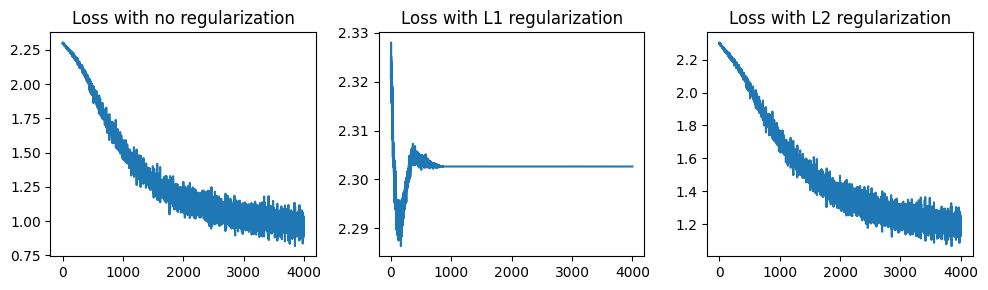

Accuracy with no regularization: 0.60
Accuracy with L1 regularization: 0.10
Accuracy with L2 regularization: 0.57


In [10]:
class Experiment34:
    def __init__(self, dataset):
        self.dataset = dataset
        self.regularizations = [0, 1, 2]
        self.names = ["no regularization", "L1 regularization", "L2 regularization"]
        self.losses = []
        self.regu_losses = []  # Regularization losses
        self.accuracies = []

    def run_experiments(self):
        for i in self.regularizations:
            print(f"Training model with {self.names[i]}...")
            model = MLP(ReLU, ReLU_derivative, regularization=i, regularization_coeff=0.01)
            loss, regu_loss, _ = model.fit(self.dataset['X_train'], self.dataset['y_train'], epochs=1000)
            self.losses.append(loss)
            self.regu_losses.append(regu_loss)

            # Evaluate the model
            _, accuracy = model.calculate_metric_given_X(self.dataset['X_test'], self.dataset['y_test'])
            self.accuracies.append(accuracy)

    def plot_results(self):
        plt.figure(figsize=(10, 3))
        for i, name in enumerate(self.names):
            plt.subplot(1, 3, i+1)
            total_loss = np.add(self.losses[i], self.regu_losses[i])
            plt.plot(total_loss)
            plt.title(f"Loss with {name}")
        plt.tight_layout()
        plt.show()

    def print_accuracies(self):
        for i, accuracy in enumerate(self.accuracies):
            print(f"Accuracy with {self.names[i]}: {accuracy:.2f}")

regularization_experiment = Experiment34(datasetF)
regularization_experiment.run_experiments()
regularization_experiment.plot_results()
regularization_experiment.print_accuracies()


### 3.5: Adding unormalized inputs

Training model with normalization...


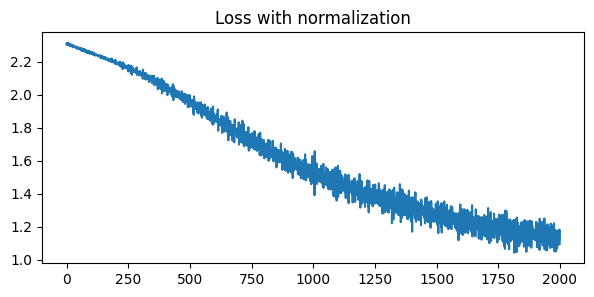

Accuracy with normalization: 0.57
Training model without normalization...


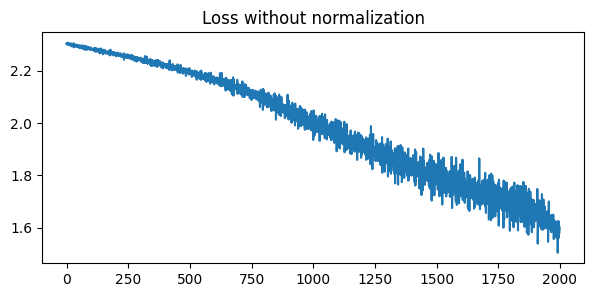

Accuracy without normalization: 0.44


In [11]:
class Experiment35:
    def __init__(self, dir, normalize=True):
        self.dir = dir
        self.losses = []
        self.accuracies = []
        self.normalize = normalize
        self.dataset = self._load_dataset()

    def _load_dataset(self):
        # Load dataset with or without normalization
        if self.normalize:
            transform = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.5), (0.5))])
        else:
            transform = tv.transforms.Compose([tv.transforms.ToTensor()])

        train_dataset = tv.datasets.FashionMNIST(root=self.dir, train=True, transform=transform, download=True)
        test_dataset = tv.datasets.FashionMNIST(root=self.dir, train=False, transform=transform, download=True)

        train_loader = t.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
        test_loader = t.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=False)

        X_train, y_train = next(iter(train_loader))
        X_test, y_test = next(iter(test_loader))

        return {
            'X_train': X_train.numpy().reshape(1024, -1),
            'y_train': y_train.numpy(),
            'X_test': X_test.numpy().reshape(10000, -1),
            'y_test': y_test.numpy()
        }

    def run_experiment(self):
        print(f"Training model {'with' if self.normalize else 'without'} normalization...")
        model = MLP(ReLU, ReLU_derivative, hidden=2, regularization=0, units=[128, 128], initializer="Xavier")
        loss, _, _ = model.fit(self.dataset['X_train'], self.dataset['y_train'], epochs=500)
        self.losses = loss

        # Evaluate the model
        _, accuracy = model.calculate_metric_given_X(self.dataset['X_test'], self.dataset['y_test'])
        self.accuracies = accuracy

    def plot_results(self):
        plt.figure(figsize=(7, 3))
        plt.plot(self.losses)
        plt.title(f"Loss {'with' if self.normalize else 'without'} normalization")
        plt.show()

    def print_accuracy(self):
        print(f"Accuracy {'with' if self.normalize else 'without'} normalization: {self.accuracies:.2f}")

# With normalization
model_runner_norm = Experiment35(dir, normalize=True)
model_runner_norm.run_experiment()
model_runner_norm.plot_results()
model_runner_norm.print_accuracy()

# Without normalization
model_runner_nonorm = Experiment35(dir, normalize=False)
model_runner_nonorm.run_experiment()
model_runner_nonorm.plot_results()
model_runner_nonorm.print_accuracy()


### 3.6: Our MLP (FashionMNIST) vs CNN (PyTorch)

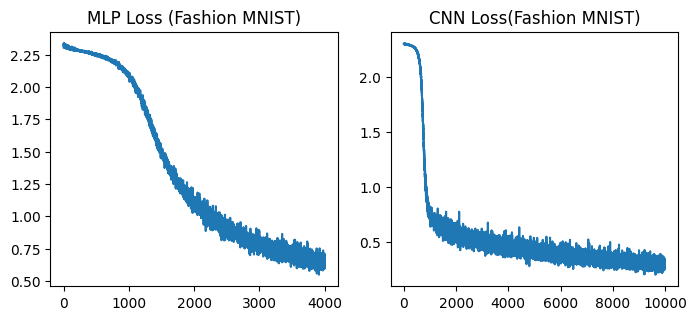

Our best MLP Loss: 0.7026075052061217
Our best MLP Accuracy: 0.731
CNN Loss: 0.48512396216392517
CNN Accuracy: 0.8256


In [12]:
class CNN_F(t.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = t.nn.Conv2d(1, 8, 5)
        self.conv2 = t.nn.Conv2d(8, 16, 3)
        self.fc1 = t.nn.Linear(16 * 5 * 5, 128)
        self.fc2 = t.nn.Linear(128, 128)
        self.fc3 = t.nn.Linear(128, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, (2, 2))
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, (2, 2))
        X = X.view(X.shape[0], -1)  # flatten the shape
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return X

def train_model(data_loader, model, loss_function, optimizer, epochs=500):
    device = t.device("cuda:0" if t.cuda.is_available() else "cpu")
    model.to(device)
    loss_per_step = []
    accuracy_per_step = []

    for epoch in range(epochs):
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)  # Move data to the same device as the model

            optimizer.zero_grad()
            outputs = model(X)
            _, predicted = t.max(outputs, 1)
            correct = (predicted == y).sum().item()
            accuracy = correct / y.size(0)

            loss = loss_function(outputs, y)
            loss.backward()
            optimizer.step()

            loss_per_step.append(loss.item())
            accuracy_per_step.append(accuracy)

    model.to('cpu')  # Return model to CPU for further operations or saving
    return loss_per_step, accuracy_per_step

def evaluate_model(model, test_data, loss_function):
    device = t.device("cuda:0" if t.cuda.is_available() else "cpu")
    model.to(device)
    
    test_data['X'], test_data['y'] = test_data['X'].to(device), test_data['y'].to(device)

    with t.no_grad():
        outputs = model(test_data['X'])
        _, predicted = t.max(outputs, 1)
        correct = (predicted == test_data['y']).sum().item()
        accuracy = correct / test_data['y'].size(0)
        loss = loss_function(outputs, test_data['y']).item()

    model.to('cpu')  # Return model to CPU after evaluation
    return accuracy, loss

# Only using 10000 samples instead of 60000 spend less time for trainning
train_loader = t.utils.data.DataLoader((t.utils.data.Subset(train_datasetF, range(10000))), batch_size=512, shuffle=True)

# Initialize the model, loss function, and optimizer
model = CNN_F()
loss_function = t.nn.CrossEntropyLoss()
optimizer = t.optim.SGD(model.parameters(), lr=0.01)
# Training the model
loss_per_step, accuracy_per_step = train_model(train_loader, model, loss_function, optimizer)

model36 = MLP(softplus, softplus_derivative, hidden=2, regularization=0, units=[128, 128], initializer="Xavier")
loss_steps36, _, accuracy_steps36 = model36.fit(datasetF['X_train'], datasetF['y_train'], epochs=1000)
loss36, accuracy36 = model36.calculate_metric_given_X(datasetF['X_test'], datasetF['y_test'])


# Plotting
titles = ["MLP Loss (Fashion MNIST)", "CNN Loss(Fashion MNIST)"]
data = [loss_steps36, loss_per_step]
plt.figure(figsize=(7, 6))
for i, (title, datum) in enumerate(zip(titles, data)):
    ax = plt.subplot(2, 2, i+1)
    ax.plot(datum)
    ax.set_title(title)
plt.tight_layout()
plt.show()

# Evaluating the model on test data
test_accuracy, test_loss = evaluate_model(model, test_dataF, loss_function)
print(f"Our best MLP Loss: {loss36}")
print(f"Our best MLP Accuracy: {accuracy36}")

print(f"CNN Loss: {test_loss}")
print(f"CNN Accuracy: {test_accuracy}")


### 3.7: Our MLP (CIFAR-10) vs CNN (PyTorch) 

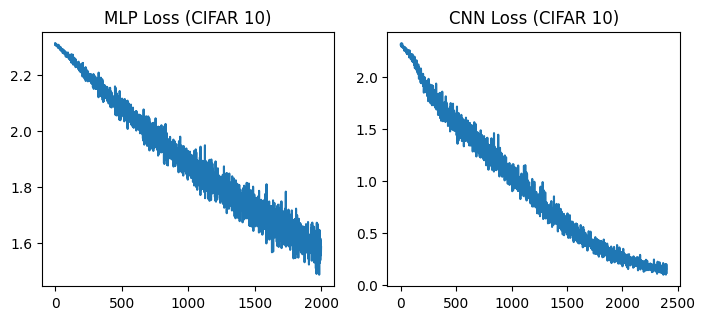

MLP Accuracy: 0.3525
CNN Accuracy: 0.42719998955726624


In [13]:
# Define MLP Model
model_mlp = MLP(ReLU, ReLU_derivative, hidden=1, regularization=0, units=[128], initializer="Xavier")
loss_mlp, _, train_accuracy_mlp = model_mlp.fit(XC, yC, epochs=500)
_, accuracy_mlp = model_mlp.calculate_metric_given_X(X_testC, y_testC)

# Define CNN Model for CIFAR10
class CNN_C(t.nn.Module):
    def __init__(self):
        super(CNN_C, self).__init__()
        # Convolutional layers
        self.conv1 = t.nn.Conv2d(3, 16, 5)
        self.bn1 = t.nn.BatchNorm2d(16)
        self.conv2 = t.nn.Conv2d(16, 32, 3)
        self.bn2 = t.nn.BatchNorm2d(32)
        # Fully-connected layers
        self.fc1 = t.nn.Linear(32 * 6 * 6, 128)
        self.drop = t.nn.Dropout(0.5)
        self.fc2 = t.nn.Linear(128, 128)
        self.fc3 = t.nn.Linear(128, 10)

    def forward(self, X):
        X = F.max_pool2d(F.relu(self.bn1(self.conv1(X))), (2, 2))
        X = F.max_pool2d(F.relu(self.bn2(self.conv2(X))), (2, 2))
        X = X.view(X.shape[0], -1)
        X = self.drop(F.relu(self.fc1(X)))
        X = F.relu(self.fc2(X))
        return self.fc3(X)

# Train the CNN Model
def train37(data_loader, model, loss_function, optimizer, epochs=500):
    loss_per_step = []
    accuracy_per_step = []
    for epoch in range(epochs):
        for X, y in data_loader:
            optimizer.zero_grad()
            outputs = model(X)
            loss = loss_function(outputs, y)
            loss.backward()
            optimizer.step()
            _, prediction = t.max(outputs, 1)
            accuracy = (prediction == y).sum().item() / y.size(0)
            loss_per_step.append(loss.item())
            accuracy_per_step.append(accuracy)
    return loss_per_step, accuracy_per_step

model_cnn = CNN_C()
loss_function_cnn = t.nn.CrossEntropyLoss()
optimizer_cnn = t.optim.SGD(model_cnn.parameters(), lr=0.01)
loss_cnn, train_accuracy_cnn = train37(subset_train_iterC, model_cnn, loss_function_cnn, optimizer_cnn, epochs=300)
test_outputs_cnn = model_cnn(X_test_tensorC)
accuracy_cnn = (t.argmax(test_outputs_cnn, 1) == y_test_tensorC).float().mean().item()

# Plotting
titles = ["MLP Loss (CIFAR 10)", "CNN Loss (CIFAR 10)"]
data = [loss_mlp, loss_cnn]
plt.figure(figsize=(7, 6))
for i, (title, datum) in enumerate(zip(titles, data)):
    ax = plt.subplot(2, 2, i+1)
    ax.plot(datum)
    ax.set_title(title)
plt.tight_layout()
plt.show()

# Print accuracies
print("MLP Accuracy:", accuracy_mlp)
print("CNN Accuracy:", accuracy_cnn)

### 3.8: Adding different optimizer (SGD & ADAM) on CNN (PyTorch)

In [14]:
def train38(model, loader, CEL, optimizer, num_epochs=500, device='cpu'):
    
    model.to(device)
    model.train()
    losses = []

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = CEL(outputs, labels) # Cross Entropy Loss
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

    return losses

def test(model, test_data, device='cpu'):
    model.to(device)
    model.eval()
    with t.no_grad():
        inputs, labels = test_data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = t.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / labels.size(0)

    return accuracy

def Experiment38(optimizerType="SGD"):
    # Set device
    device = t.device('cuda' if t.cuda.is_available() else 'cpu')
    
    params_list = []
    train_losses38 = []
    accuracies38 = []
    
    if optimizerType == "SGD":
        momentums = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8]
        params_list = momentums
        for momentum in momentums:
            model = CNN_C().to(device)
            CEL = t.nn.CrossEntropyLoss()
            optimizer = t.optim.SGD(model.parameters(), lr=0.01, momentum=momentum)
            loss_sgd = train38(model, subset_train_iterC, CEL, optimizer, device=device)
            train_losses38.append(loss_sgd)
            accuracy = test(model, (X_test_tensorC, y_test_tensorC), device)
            accuracies38.append(accuracy)

    elif optimizerType == "ADAM":
        learning_rates = [0.0001, 0.001, 0.01, 0.1]
        params_list = learning_rates
        for lr in learning_rates:
            model = CNN_C().to(device)
            CEL = t.nn.CrossEntropyLoss()
            optimizer = t.optim.Adam(model.parameters(), lr=lr)
            loss_adam = train38(model, subset_train_iterC, CEL, optimizer, device=device)
            train_losses38.append(loss_adam)
            accuracy = test(model, (X_test_tensorC, y_test_tensorC), device)
            accuracies38.append(accuracy)
            
    # Plotting
    plt.figure(figsize=(14, 9))
    for i, accuracy in enumerate(accuracies38):
        plt.subplot(3, 4, i + 1)
        if optimizerType == "SGD":
            plt.title(f"SGD -- Loss with {params_list[i]} momentum")
        else:
            plt.title(f"Adam -- Loss with lr={params_list[i]}")
        plt.plot(train_losses38[i])
    plt.tight_layout()
    plt.show()
    print(f"Accuracy: {accuracies38}")

# Run the experiment
Experiment38(optimizerType="SGD")
Experiment38(optimizerType="ADAM")

### 3.9: Pre-trained model (ResNet), and adding different number of layers on it.

Epoch 1, Loss: 1.8332, Accuracy: 35.76%
Epoch 2, Loss: 1.0910, Accuracy: 61.97%
Epoch 3, Loss: 0.8081, Accuracy: 72.03%
Epoch 4, Loss: 0.6282, Accuracy: 78.39%
Epoch 5, Loss: 0.4891, Accuracy: 83.29%
Epoch 6, Loss: 0.3709, Accuracy: 87.70%
Epoch 7, Loss: 0.2797, Accuracy: 90.80%
Epoch 8, Loss: 0.2089, Accuracy: 93.33%
Epoch 9, Loss: 0.1536, Accuracy: 95.36%
Epoch 10, Loss: 0.1230, Accuracy: 96.27%
Epoch 11, Loss: 0.0989, Accuracy: 97.00%
Epoch 12, Loss: 0.0844, Accuracy: 97.44%
Epoch 13, Loss: 0.0755, Accuracy: 97.72%
Epoch 14, Loss: 0.0671, Accuracy: 97.91%
Epoch 15, Loss: 0.0619, Accuracy: 98.01%
Epoch 16, Loss: 0.0555, Accuracy: 98.26%
Epoch 17, Loss: 0.0513, Accuracy: 98.39%
Epoch 18, Loss: 0.0496, Accuracy: 98.47%
Epoch 19, Loss: 0.0501, Accuracy: 98.41%
Epoch 20, Loss: 0.0431, Accuracy: 98.68%


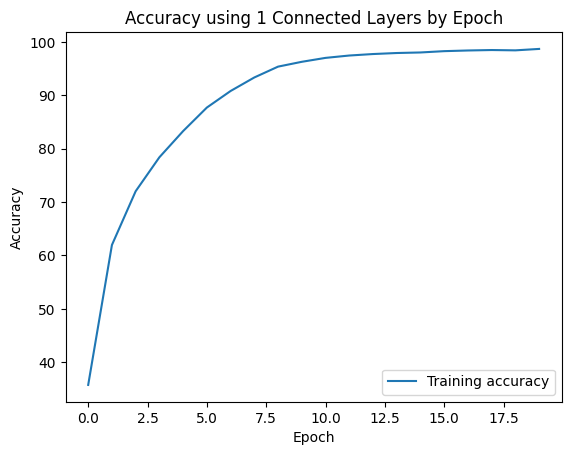

5min 58s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Epoch 1, Loss: 1.6095, Accuracy: 43.15%
Epoch 2, Loss: 0.9565, Accuracy: 66.41%
Epoch 3, Loss: 0.7246, Accuracy: 74.65%
Epoch 4, Loss: 0.5554, Accuracy: 80.80%
Epoch 5, Loss: 0.4245, Accuracy: 85.44%
Epoch 6, Loss: 0.3206, Accuracy: 89.23%
Epoch 7, Loss: 0.2349, Accuracy: 92.16%
Epoch 8, Loss: 0.1839, Accuracy: 93.97%
Epoch 9, Loss: 0.1428, Accuracy: 95.21%
Epoch 10, Loss: 0.1168, Accuracy: 96.12%
Epoch 11, Loss: 0.1005, Accuracy: 96.75%
Epoch 12, Loss: 0.0882, Accuracy: 97.06%
Epoch 13, Loss: 0.0799, Accuracy: 97.33%
Epoch 14, Loss: 0.0704, Accuracy: 97.64%
Epoch 15, Loss: 0.0699, Accuracy: 97.81%
Epoch 16, Loss: 0.0654, Accuracy: 97.81%
Epoch 17, Loss: 0.0630, Accuracy: 97.86%
Epoch 18, Loss: 0.0591, Accuracy: 97.98%
Epoch 19, Loss: 0.0583, Accuracy: 98.02%
Epoch 20, Loss: 0.0532, Accuracy: 98.23%


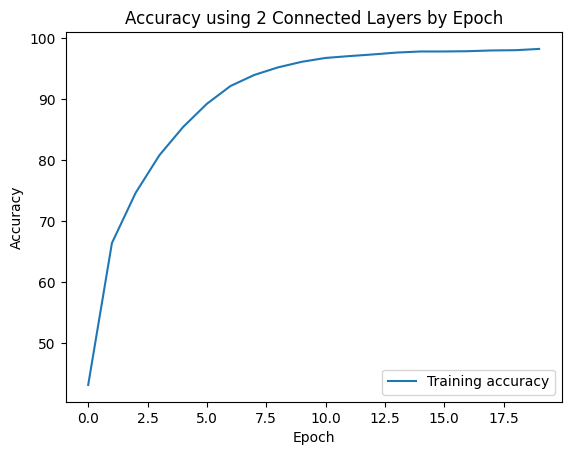

5min 45s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Epoch 1, Loss: 1.5675, Accuracy: 43.99%
Epoch 2, Loss: 0.9510, Accuracy: 66.44%
Epoch 3, Loss: 0.7261, Accuracy: 74.55%
Epoch 4, Loss: 0.5632, Accuracy: 80.30%
Epoch 5, Loss: 0.4435, Accuracy: 84.47%
Epoch 6, Loss: 0.3440, Accuracy: 88.08%
Epoch 7, Loss: 0.2651, Accuracy: 90.93%
Epoch 8, Loss: 0.2166, Accuracy: 92.59%
Epoch 9, Loss: 0.1662, Accuracy: 94.33%
Epoch 10, Loss: 0.1434, Accuracy: 95.11%
Epoch 11, Loss: 0.1185, Accuracy: 95.89%
Epoch 12, Loss: 0.1044, Accuracy: 96.43%
Epoch 13, Loss: 0.0998, Accuracy: 96.66%
Epoch 14, Loss: 0.0897, Accuracy: 97.02%
Epoch 15, Loss: 0.0792, Accuracy: 97.25%
Epoch 16, Loss: 0.0755, Accuracy: 97.46%
Epoch 17, Loss: 0.0710, Accuracy: 97.59%
Epoch 18, Loss: 0.0636, Accuracy: 97.85%
Epoch 19, Loss: 0.0558, Accuracy: 98.10%
Epoch 20, Loss: 0.0601, Accuracy: 97.98%


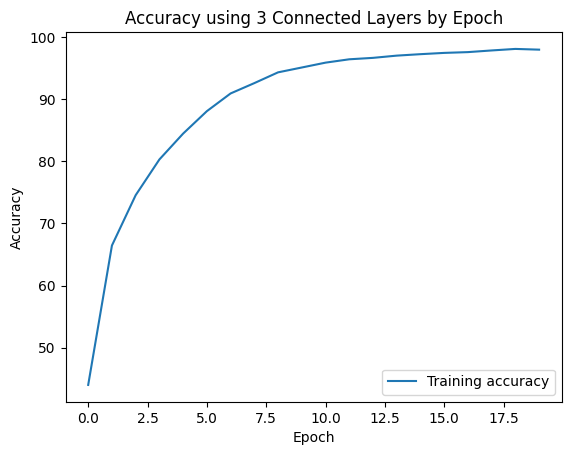

5min 52s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
def create_model(layers):
    # Load the pre-trained ResNeXt50 model
    base_model = models.resnext50_32x4d(pretrained=True)
    base_model.fc = nn.Identity()   # Get rid of the fully connected layers in the pre-trained model
    dim = 2048
    # Freeze only the convolutional layers, according to the structure of ResNeXt
    for name, param in base_model.named_parameters():
        if 'conv' in name:
            param.requires_grad = False

    # Modify the model to include new layers
    features = base_model
    maxpool_layer = nn.AdaptiveMaxPool2d((1, 1))
    softmax = nn.Softmax(dim=1)
    if layers == 1:
        model = nn.Sequential(features, nn.Linear(dim, 10)) # Simulate the original ResNeXt fully connected layer structure for benchmark
    # Depending on the number of layers, create the model architecture
    if layers == 2:
        layer1 = nn.Linear(dim, 256)
        activation = nn.ReLU()
        layer2 = nn.Linear(256, 10)
        model = nn.Sequential(
            features,
            layer1,
            activation,
            layer2,
        )
    elif layers == 3:
        layer1 = nn.Linear(dim, 512)
        activation1 = nn.ReLU()
        layer2 = nn.Linear(512, 256)
        activation2 = nn.ReLU()
        layer3 = nn.Linear(256, 10)
        model = nn.Sequential(
            features,
            layer1,
            activation1,
            layer2,
            activation2,
            layer3,
        )

    return model

def train_and_plot(model, title):
    device = t.device("cuda" if t.cuda.is_available() else "cpu")
    model = model.to(device)

    # Define the loss function and the optimizer
    CEL = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

    # Training loop
    trainloader = t.utils.data.DataLoader(train_datasetC, batch_size=128, shuffle=True, num_workers=2)
    num_epochs = 20
    training_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = CEL(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            running_loss += loss.item()

        epoch_accuracy = 100 * correct / total
        training_accuracies.append(epoch_accuracy)
        print(f"Epoch {epoch+1}, Loss: {running_loss/i:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    # Plotting
    plt.plot(training_accuracies, label="Training accuracy")
    plt.legend(loc="lower right")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.show()

# Train and plot for original model
model_1_layers = create_model(1) # Get fit time using %timeit function
%timeit -n 1 -r1 train_and_plot(model_1_layers, "Accuracy using 1 Connected Layers by Epoch")

# Train and plot for 2 layers
model_2_layers = create_model(2) # Get fit time using %timeit function
%timeit -n 1 -r1 train_and_plot(model_2_layers, "Accuracy using 2 Connected Layers by Epoch")

# Train and plot for 3 layers
model_3_layers = create_model(3) # Get fit time using %timeit function
%timeit -n 1 -r1 train_and_plot(model_3_layers, "Accuracy using 3 Connected Layers by Epoch")
